In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import subprocess

import scipy.signal
from nistats import hemodynamic_models

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/ppi')
os.makedirs(path_out, exist_ok=True)

# Timeseries directory
path_timeries = os.path.join(path_out, 'timeseries')

# Load timeseries
time_series_all = np.load(os.path.join(path_timeries, 'time_series_clean_all.npy'))

n_volumes, t_r = 730, 2

### Sample and store hemodynamic response function

In [3]:
hrf_duration = 26

hrf_spm = hemodynamic_models.spm_hrf(
    t_r, 
    oversampling=1, 
    time_length=hrf_duration, 
    onset=0.0
    )
hrf_glover = hemodynamic_models.glover_hrf(
    t_r, 
    oversampling=1,
    time_length=hrf_duration, 
    onset=0.0
    )

pd.Series(hrf_spm).to_csv(os.path.join(path_timeries, 'spmHRF.1D'), index=False, header=False)
pd.Series(hrf_glover).to_csv(os.path.join(path_timeries, 'gloverHRF.1D'), index=False, header=False)

print(f'HRF samples counts: {len(hrf_spm)}')

HRF samples counts: 13


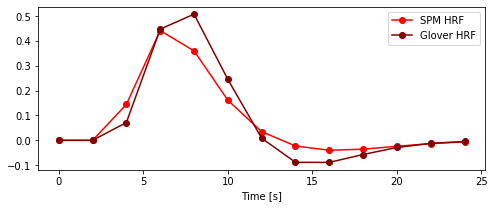

In [11]:
fig, ax = plt.subplots(figsize=(8, 3), facecolor='w')

x_vals = np.arange(0, hrf_duration, t_r) 

ax.plot(x_vals, hrf_spm, 'o-', color='r', label='SPM HRF')
ax.plot(x_vals, hrf_glover, 'o-', color='maroon', label='Glover HRF')

ax.set_xlabel('Time [s]')
ax.legend()
plt.show()

### Deconvolve

In [5]:
### Inputs #########################################################################################

path_hrf = os.path.join(path_timeries, 'spmHRF.1D')
ts = time_series_all[0, 0, :, 0]

### Function #######################################################################################

ts_fname, ts_neural_fname = 'ts.1D', 'ts_neural.1D'

pd.Series(ts).to_csv(ts_fname, index=False, header=False)

# Deconvolve
cmd = f'3dTfitter -RHS {ts_fname} -FALTUNG {path_hrf} {ts_neural_fname} 012 0'
subprocess.run(cmd, shell=True)

ts_neural = np.loadtxt(ts_neural_fname)

os.remove(ts_fname)
os.remove(ts_neural_fname)

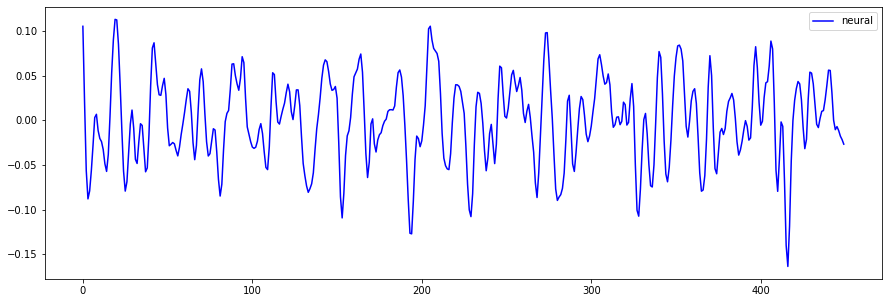

In [16]:
fig, ax = plt.subplots(figsize=(15, 5), facecolor='w')

# ax.plot(normalize_1d(ts[:450]), 'r', label='BOLD')
ax.plot(normalize_1d(ts_neural[:450]), 'b', label='neural')
ax.legend()

/home/kmb/anaconda3/envs/decidenet/lib/python3.8/site-packages/nistats/hemodynamic_models.py:61: RuntimeWarning: invalid value encountered in true_divide
  hrf /= hrf.sum()


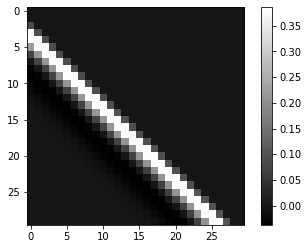

In [33]:
n_volumes = 500
spm_hrf_matrix = np.zeros((n_volumes, n_volumes))

for vol in range(n_volumes):
    spm_hrf_matrix[:, vol] = hemodynamic_models.spm_hrf(
        t_r, 
        oversampling=1, 
        time_length=t_r*n_volumes, 
        onset=float(vol*t_r)
    )
    
spm_hrf_matrix = np.nan_to_num(spm_hrf_matrix)
    
plt.imshow(spm_hrf_matrix[:30,:30], cmap='gray')
plt.colorbar()
plt.show()

In [8]:
neural_condition = np.zeros((3, n_volumes))
frame_times = np.arange(0, n_volumes*t_r, t_r)

for vol, amplitude in enumerate(ts_neural):
    neural_condition[:, vol] = (vol * t_r, 0, amplitude)
    
ts_recreated_upsampled = hemodynamic_models.compute_regressor(
    neural_condition, 
    'spm', 
    frame_times,
    oversampling=50, 
    fir_delays=None)[0].ravel()

ts_recreated = spm_hrf_matrix.dot(ts_neural)

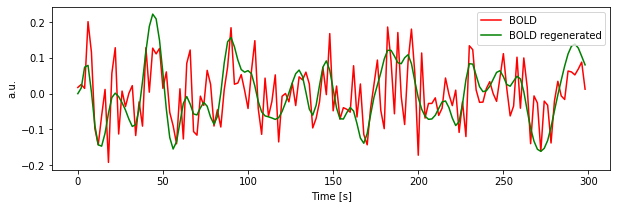

In [9]:
from sklearn.preprocessing import normalize
normalize_1d = lambda  x: normalize(x[:,np.newaxis], axis=0).ravel()

fig, ax = plt.subplots(figsize=(10, 3), facecolor='w')

ax.plot(np.arange(0, 300, 2), normalize_1d(ts[:150]), 'r', label='BOLD')
ax.plot(np.arange(0, 300, 2), normalize_1d(ts_recreated_upsampled[:150]), 'g', label='BOLD regenerated')

ax.set_xlabel('Time [s]')
ax.set_ylabel('a.u.')

ax.legend()
plt.show()